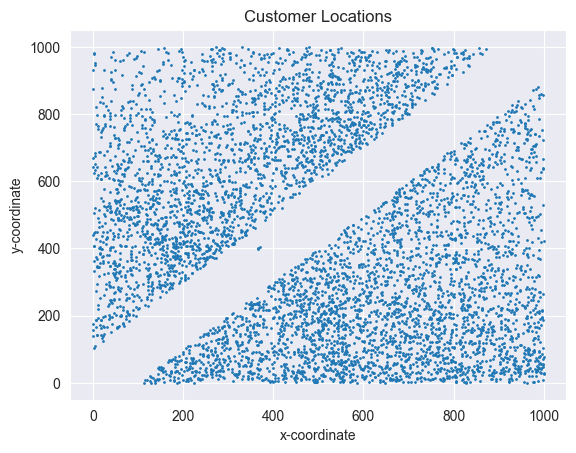

In [127]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('datasets/drone_cust_locations.csv', sep=';').drop('clientid', axis=1)

X = df['x']
y = df['y']

plt.scatter(X, y, s=1)
plt.xlabel('x-coordinate')
plt.ylabel('y-coordinate')
plt.title('Customer Locations')
plt.show()


In [128]:
from sklearn.cluster import KMeans

model = KMeans(init='random', n_clusters=3, random_state=42)
model.fit(df)

model.cluster_centers_

array([[702.08109226, 211.2703835 ],
       [198.44098904, 383.25861847],
       [548.20586479, 787.2788963 ]])

In [129]:
clusters = model.predict(df)

df_with_clusters = df.copy()
df_with_clusters['depot'] = clusters

df_with_clusters.head(10)

,x,y,depot
0,622.771572,164.857623,0
1,416.357298,630.193634,2
2,292.735020,567.333231,1
3,737.211288,166.225676,0
4,540.475375,682.912298,2
5,535.469492,318.439661,0
6,640.380050,870.833221,2
7,235.772075,359.048203,1
8,481.896884,661.491838,2
9,730.032789,312.177817,0


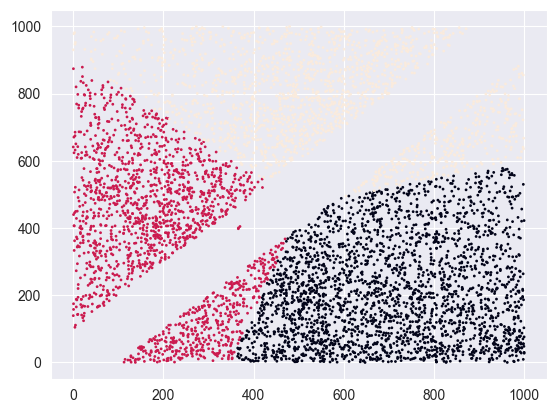

In [130]:
plt.scatter(df_with_clusters['x'], df_with_clusters['y'], c=df_with_clusters['depot'], s=1)

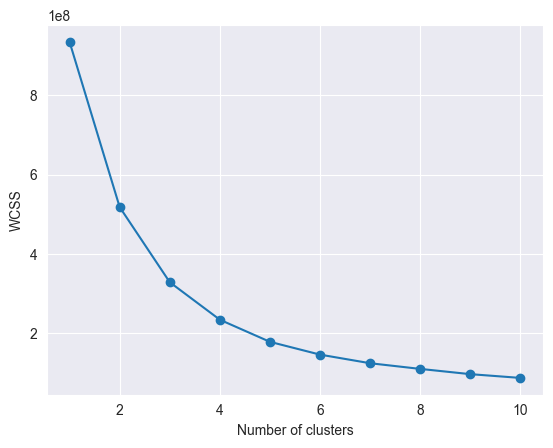

In [131]:
import matplotlib.pyplot as plt

wcss = []
for i in range(1,11):
    model = KMeans(init='random', n_clusters=i, random_state=42).fit(df)
    wcss.append(model.inertia_)

plt.plot(range(1,11), wcss, 'o-')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [132]:
from sklearn.metrics import silhouette_score

model = KMeans(init='random', n_clusters=10, random_state=42)

model.fit(df)
model.cluster_centers_

print(f'Silhouette score: {silhouette_score(df, model.labels_)}')

Silhouette score: 0.36632391559826993


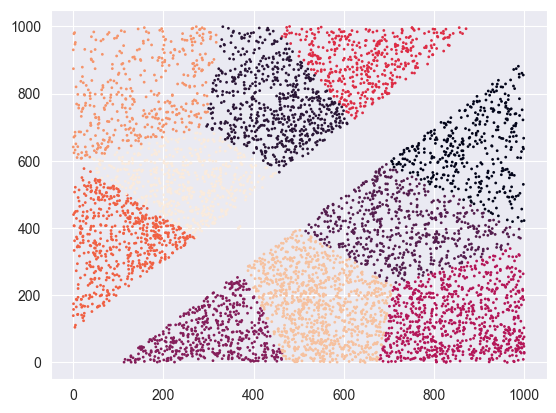

In [133]:
clusters = model.predict(df)

df_with_clusters = df.copy()
df_with_clusters['depot'] = clusters

plt.scatter(df_with_clusters['x'], df_with_clusters['y'], c=df_with_clusters['depot'], s=1)

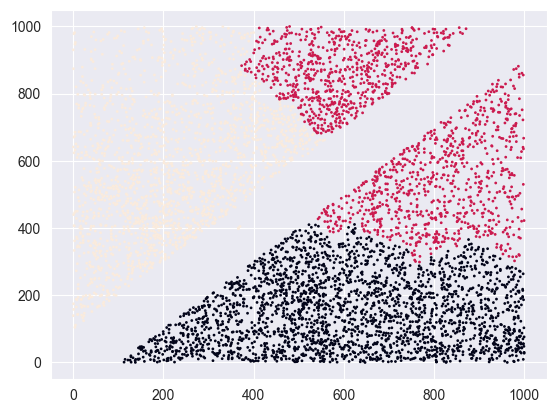

In [134]:
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(n_clusters=3)
clusters = model.fit_predict(df)

df_with_clusters = df.copy()
df_with_clusters['depot'] = clusters

plt.scatter(df_with_clusters['x'], df_with_clusters['y'], c=df_with_clusters['depot'], s=1)

In [175]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules

df = pd.read_csv('datasets/drone_prod_groups(1).csv', sep=',', dtype=int).drop('ID', axis=1)

df = df.replace({1: True, 0: False})
frequent_itemsets = apriori(df, min_support=0.1, use_colnames=True)
frequent_itemsets

# generate association rules

rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.5)

# sort in descending order of confidence
rules = rules.sort_values(by='confidence', ascending=False)

rules

C:\Users\samul\AppData\Local\Temp\ipykernel_31624\1314675021.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({1: True, 0: False})


,support,itemsets
0,0.10998,( Prod1)
1,0.13098,( Prod2)
2,0.10459,( Prod5)
3,0.13499,( Prod7)
4,0.16179,( Prod8)
5,0.19853,( Prod9)
6,0.10848,( Prod11)
7,0.15971,( Prod12)
8,0.14557,( Prod14)
9,0.11880,( Prod15)


In [182]:
# generate association rules

rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.5)

# sort in descending order of confidence
rules = rules.sort_values(by='confidence', ascending=False)


rules = rules.drop(rules.columns[11:], axis=1)

rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric
1,( Prod15),( Prod9),0.11880,0.19853,0.11145,0.938131,4.725388,1.0,0.087865,12.954372,0.894663
2,( Prod20),( Prod19),0.14798,0.20626,0.13476,0.910664,4.415125,1.0,0.104238,8.884845,0.907849
3,( Prod19),( Prod20),0.20626,0.14798,0.13476,0.653350,4.415125,1.0,0.104238,2.457869,0.974508
0,( Prod9),( Prod15),0.19853,0.11880,0.11145,0.561376,4.725388,1.0,0.087865,2.009011,0.983664
